In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# print the graphs in the notebook
%matplotlib inline

# set seaborn style to white
sns.set_style("white")
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Understanding the data with simple EDA

In [3]:
df = pd.read_csv("/kaggle/input/customer-spending-dataset/customer_data.csv")
df.head()

,name,age,gender,education,income,country,purchase_frequency,spending
0,Teresa Williams MD,42,Female,High School,53936,Slovenia,0.9,13227.120
1,Christine Myers,49,Female,Master,82468,Aruba,0.6,12674.040
2,Dwayne Moreno,55,Male,Bachelor,56941,Cyprus,0.3,5354.115
3,Amy Norton,24,Female,Bachelor,60651,Palau,0.2,2606.510
4,Tonya Adams,64,Male,Master,81884,Zambia,0.9,18984.780


In [4]:
df.dtypes

name                   object
age                     int64
gender                 object
education              object
income                  int64
country                object
purchase_frequency    float64
spending              float64
dtype: object

In [5]:
df.isna().sum()

name                  0
age                   0
gender                0
education             0
income                0
country               0
purchase_frequency    0
spending              0
dtype: int64

In [6]:
df.describe()

,age,income,purchase_frequency,spending
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.754000,59277.852000,0.554600,9613.296835
std,13.778582,23258.377128,0.284675,5484.707210
min,18.000000,20031.000000,0.100000,611.985000
25%,30.000000,38825.500000,0.300000,5020.425000
50%,42.000000,58972.000000,0.600000,9430.395000
75%,54.000000,79114.000000,0.800000,13645.507500
max,65.000000,99780.000000,1.000000,25546.500000


In [7]:
df.gender.value_counts()

Male      501
Female    499
Name: gender, dtype: int64

In [8]:
print("There are",df.country.nunique(), "unique countries in the dataset.")

There are 239 unique countries in the dataset.


In [9]:
df.education.value_counts()

Bachelor       271
PhD            248
High School    245
Master         236
Name: education, dtype: int64

**Data looks pretty clean and balanced in general, but we have to deal with string data later.**

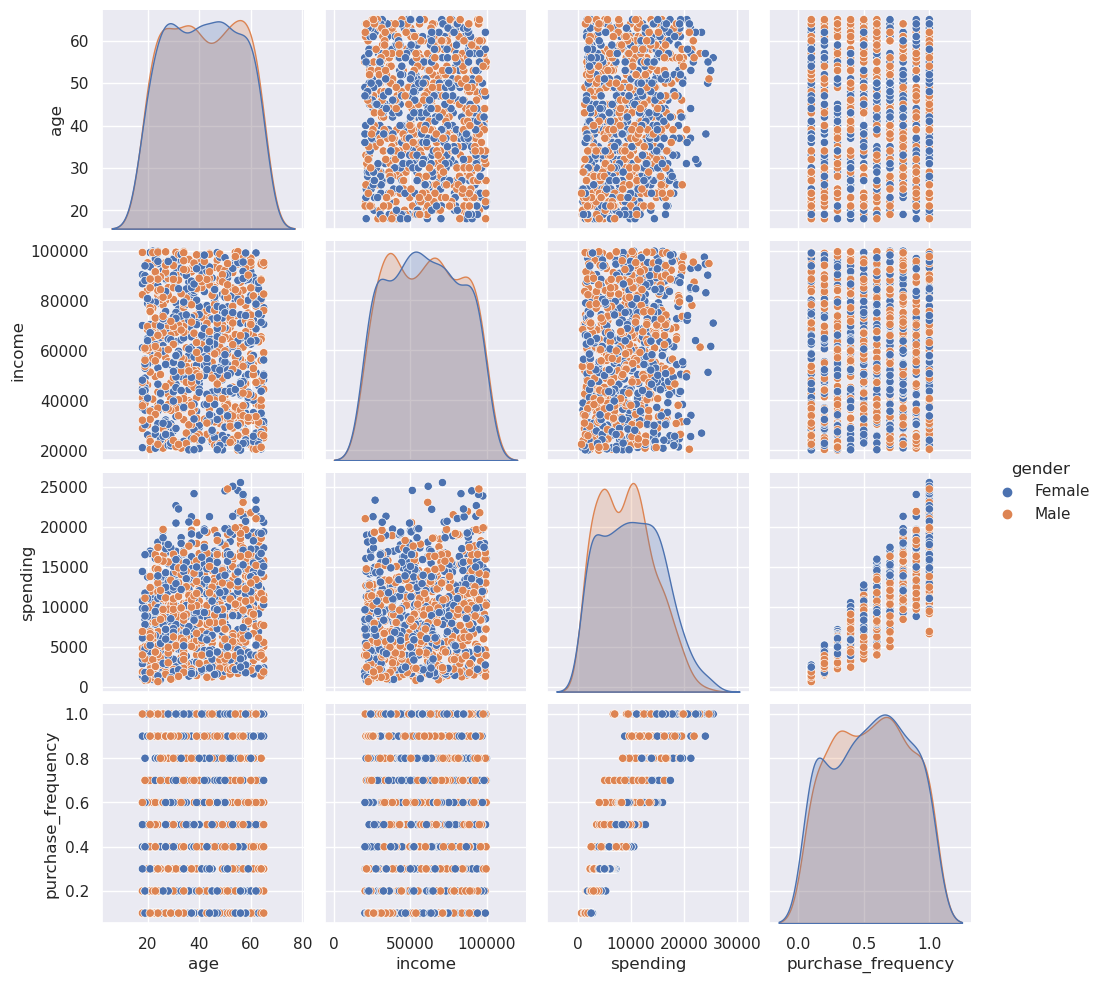

In [10]:
sns.set(rc = {"figure.figsize":(5,2.5)})

sns.pairplot(df, vars=['age','income','spending', 'purchase_frequency'],hue='gender',)

Text(0.5, 1.0, 'Distribution of age')

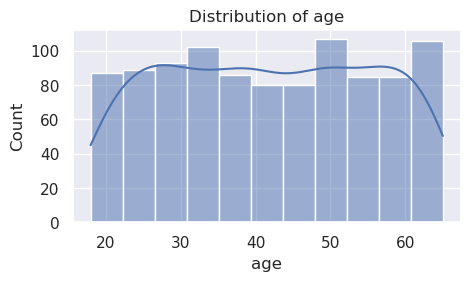

In [11]:
sns.histplot(df.age, kde=True)
plt.title("Distribution of age")

Text(0.5, 1.0, 'Distribution of spending')

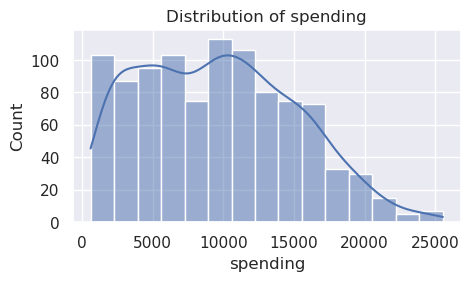

In [12]:
sns.histplot(df.spending, kde=True)
plt.title("Distribution of spending")

Text(0.5, 1.0, 'Distribution of income')

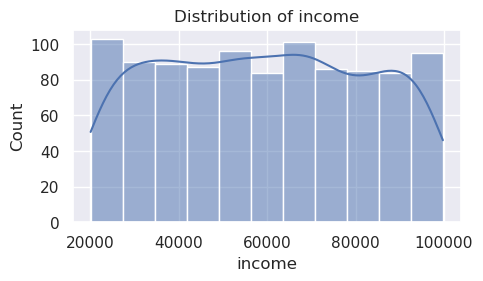

In [13]:
sns.histplot(df.income, kde=True)
plt.title("Distribution of income")

Text(0.5, 1.0, 'Distribution of income by eduation level')

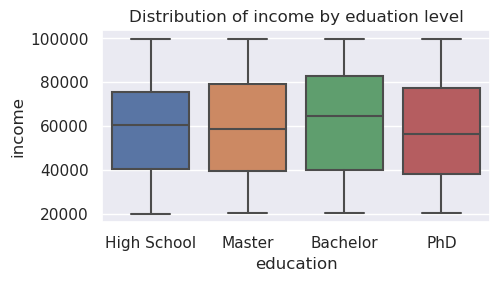

In [14]:
sns.boxplot(x=df.education,y=df.income)
plt.title("Distribution of income by eduation level")

Text(0.5, 1.0, 'Distribution of spending by eduation level')

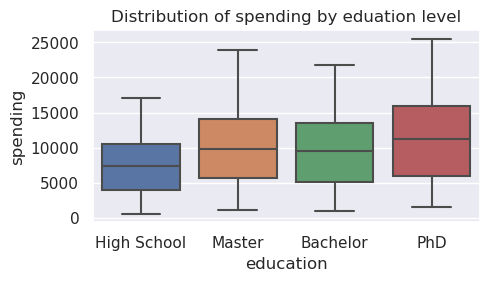

In [15]:
sns.boxplot(x=df.education,y=df.spending)
plt.title("Distribution of spending by eduation level")

Text(0.5, 1.0, 'Distribution of age by eduation level')

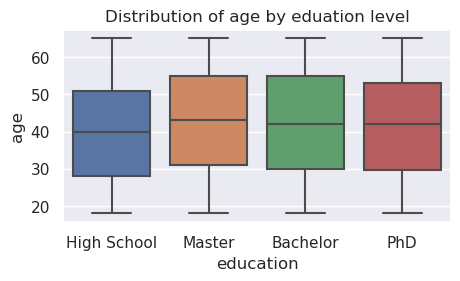

In [16]:
sns.boxplot(x=df.education,y=df.age)
plt.title("Distribution of age by eduation level")

Text(0.5, 1.0, 'Distribution of spending by purchase frequency')

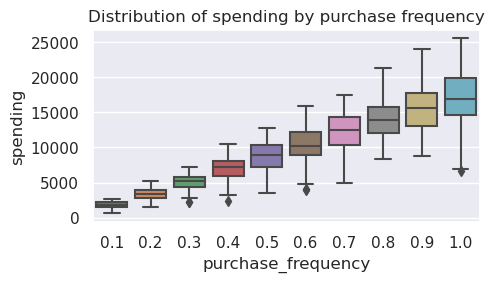

In [17]:
sns.boxplot(x=df.purchase_frequency,y=df.spending)
plt.title("Distribution of spending by purchase frequency")

These EDA analysis really show how randomly and unnaturally fairly these data are being distrubted. The only significant relationship that we can observe is that the higher the purchase frequency, the higher the spending.

# Data Preprocessing and PCA

In this section we will mainly be handling the string data and scale the dataset to be prepare to pass the data through PCA.

### **One Hot Encoding**

In [18]:
df_preprocess = df.join(pd.get_dummies(df.education)).drop('education',axis=1)
df_preprocess.head()

,name,age,gender,income,country,purchase_frequency,spending,Bachelor,High School,Master,PhD
0,Teresa Williams MD,42,Female,53936,Slovenia,0.9,13227.120,0,1,0,0
1,Christine Myers,49,Female,82468,Aruba,0.6,12674.040,0,0,1,0
2,Dwayne Moreno,55,Male,56941,Cyprus,0.3,5354.115,1,0,0,0
3,Amy Norton,24,Female,60651,Palau,0.2,2606.510,1,0,0,0
4,Tonya Adams,64,Male,81884,Zambia,0.9,18984.780,0,0,1,0


In [19]:
df_preprocess = df_preprocess.join(pd.get_dummies(df.gender)).drop('gender',axis=1)
df_preprocess.head()

,name,age,income,country,purchase_frequency,spending,Bachelor,High School,Master,PhD,Female,Male
0,Teresa Williams MD,42,53936,Slovenia,0.9,13227.120,0,1,0,0,1,0
1,Christine Myers,49,82468,Aruba,0.6,12674.040,0,0,1,0,1,0
2,Dwayne Moreno,55,56941,Cyprus,0.3,5354.115,1,0,0,0,0,1
3,Amy Norton,24,60651,Palau,0.2,2606.510,1,0,0,0,1,0
4,Tonya Adams,64,81884,Zambia,0.9,18984.780,0,0,1,0,0,1


In [20]:
df_preprocess = df_preprocess.join(pd.get_dummies(df.country)).drop('country',axis=1)
df_preprocess.head()

,name,age,income,purchase_frequency,spending,Bachelor,High School,Master,PhD,Female,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,Teresa Williams MD,42,53936,0.9,13227.120,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Christine Myers,49,82468,0.6,12674.040,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Dwayne Moreno,55,56941,0.3,5354.115,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Amy Norton,24,60651,0.2,2606.510,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Tonya Adams,64,81884,0.9,18984.780,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### **Scale the data with MinMaxScaler**

Now we are going to scale the data using MinMaxScaler

In [21]:
scaler = MinMaxScaler()
df_preprocess['income'] = scaler.fit_transform(df_preprocess.income.values.reshape(-1,1))
df_preprocess['age'] = scaler.fit_transform(df_preprocess.age.values.reshape(-1,1))
df_preprocess['spending'] = scaler.fit_transform(df_preprocess.spending.values.reshape(-1,1))

In [22]:
from sklearn.decomposition import PCA
df_num = df_preprocess[['age','income','purchase_frequency', 'spending', 
             'Female', 'Male', 'Bachelor', 'High School', 'Master', 'PhD']]
pca = PCA(n_components=2)
pca_df2 = pd.DataFrame(pca.fit_transform(df_num))
pca.explained_variance_

array([0.50238246, 0.26424542])

Text(0.5, 1.0, 'PC1 against PC2')

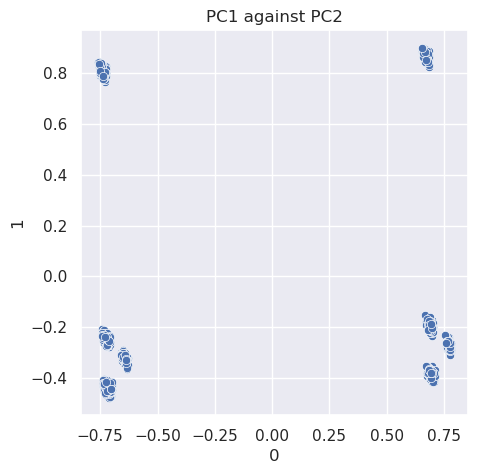

In [23]:
sns.set(rc = {"figure.figsize":(5,5)})

sns.scatterplot(x=pca_df2.iloc[:,0], y=pca_df2.iloc[:,1])
plt.title('PC1 against PC2')

Surprisingly enough, after passing the dataset through PCA, we can clearly see 8 clusters from the scatterplot

# K-Mean Clustering

K-mean clustering is a clustering method that first pick n random centroid and group the datapoints into n groups based on the distance between the datapoint and each centroid (assign to the closest centroid). And then it will re-adjust the centroid of each group and repeat the process until it hit the max_iter or it is not giving any changes.

In [24]:
kmean = KMeans(n_clusters=8)
group = kmean.fit_predict(pca_df2)
group

array([7, 1, 3, 2, 0, 5, 4, 6, 4, 7, 3, 0, 1, 0, 1, 3, 5, 3, 1, 1, 7, 1,
       7, 5, 6, 6, 4, 6, 4, 4, 6, 6, 4, 2, 3, 4, 1, 2, 0, 3, 1, 5, 0, 5,
       5, 0, 7, 5, 3, 1, 6, 0, 5, 7, 7, 6, 1, 5, 3, 3, 1, 6, 1, 7, 2, 1,
       4, 4, 0, 7, 6, 1, 4, 2, 6, 6, 6, 3, 6, 5, 5, 6, 3, 1, 6, 7, 4, 6,
       2, 5, 6, 1, 5, 3, 7, 4, 0, 5, 2, 0, 2, 4, 2, 3, 2, 6, 3, 1, 7, 4,
       5, 7, 7, 3, 3, 6, 3, 4, 3, 1, 6, 4, 2, 5, 4, 1, 4, 4, 5, 5, 7, 3,
       5, 2, 4, 5, 0, 5, 1, 6, 5, 2, 0, 3, 1, 6, 1, 3, 5, 1, 5, 4, 7, 5,
       4, 6, 3, 4, 0, 2, 3, 5, 2, 3, 3, 0, 4, 5, 6, 0, 2, 4, 6, 1, 3, 2,
       1, 1, 6, 7, 7, 3, 4, 3, 1, 2, 1, 6, 0, 7, 7, 2, 1, 1, 0, 3, 3, 3,
       2, 0, 3, 5, 0, 0, 6, 2, 0, 3, 6, 0, 2, 0, 5, 5, 5, 3, 3, 6, 2, 5,
       0, 0, 5, 5, 7, 4, 0, 2, 1, 2, 2, 6, 1, 5, 4, 1, 1, 3, 5, 4, 1, 3,
       7, 6, 0, 3, 4, 3, 5, 1, 7, 5, 1, 1, 6, 7, 4, 5, 3, 3, 6, 7, 2, 1,
       2, 0, 2, 2, 0, 1, 1, 3, 6, 5, 0, 1, 5, 1, 7, 3, 0, 5, 1, 0, 3, 4,
       3, 0, 7, 1, 3, 4, 4, 0, 6, 4, 2, 4, 7, 5, 5,

In [25]:
pca_df3 = pca_df2.copy()
pca_df3['cluster_group'] = group
pca_df3.head()

,0,1,cluster_group
0,-0.652012,-0.317518,7
1,-0.726356,-0.229135,1
2,0.677086,0.863488,3
3,-0.727731,0.786309,2
4,0.672609,-0.157958,0


In [26]:
kmean.cluster_centers_

array([[ 0.68674043, -0.19220694],
       [-0.72426984, -0.24582395],
       [-0.74001735,  0.80632852],
       [ 0.670972  ,  0.8633847 ],
       [ 0.69376054, -0.38453278],
       [-0.71758529, -0.4392216 ],
       [ 0.76814321, -0.26789365],
       [-0.64303432, -0.32369418]])

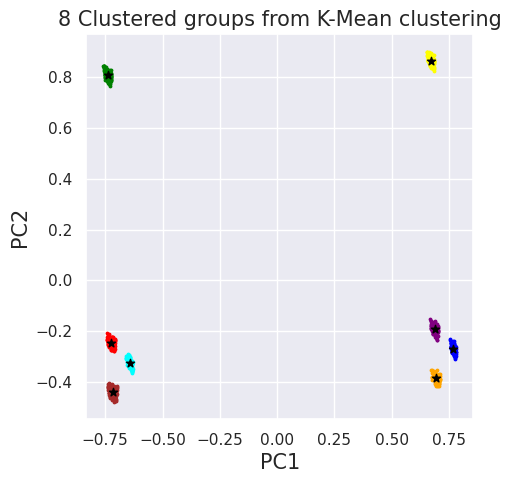

In [27]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
colors = ['purple', 'red', 'green', 'yellow', 'orange', 'brown', 'blue', 'cyan']
for group in range(0,8):
    ax.scatter(x=pca_df3.iloc[:,0][pca_df3.cluster_group == group], y=pca_df3.iloc[:,1][pca_df3.cluster_group == group],  c=colors[group], s=3)

plt.scatter(kmean.cluster_centers_[:,0], kmean.cluster_centers_[:,1], color='black', marker='*' )
plt.title("8 Clustered groups from K-Mean clustering", fontsize=15)
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)
plt.show()

## Elbow method

In fact, in most cases, we will not be able to directly spot the clusters just by observations. To find the optimal number of clusters, there are several methods assist you to do that, one of which is the elbow method.

The elbow method basically run the KMeans on a range of cluster that you would like it to test and plot a graph based on the sum of squared error of each cluster. Noted that we use the squared error in order to give a higher penalty for points that are further to the center of cluster. 

The goal of elbow method is to determine a point where the curve suddenly bents like the elbow and take that particular x-value as the number of clusters, as demonstrated below.

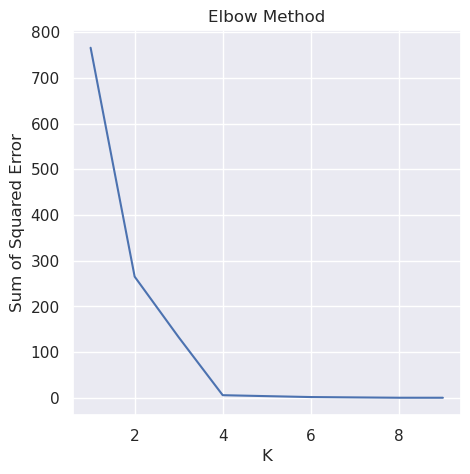

In [28]:
k_range = range(1,10)
sse = []
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(pca_df2)
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of Squared Error')
plt.title('Elbow Method')
plt.plot(k_range,sse)

Using the elbow method, it actually came up to the conclusion that we should choose 4 cluster as the number of clusters, let's see what will it return using the elbow method.

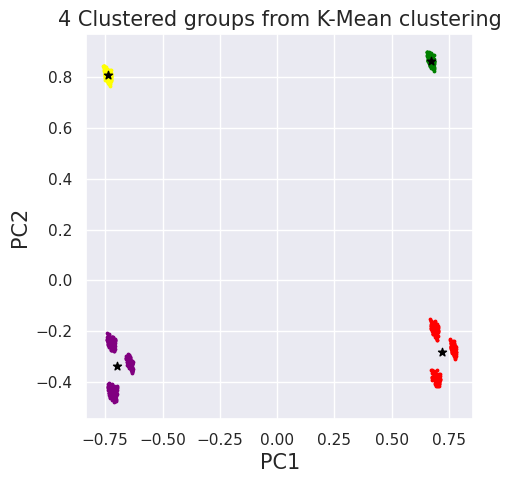

In [29]:
kmean_4 = KMeans(n_clusters=4)
group_4 = kmean_4.fit_predict(pca_df2)

pca_df4 = pca_df2.copy()
pca_df4['cluster_group'] = group_4

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
colors = ['purple', 'red', 'green', 'yellow', 'orange', 'brown', 'blue', 'cyan']
for group in range(0,4):
    ax.scatter(x=pca_df4.iloc[:,0][pca_df4.cluster_group == group], y=pca_df4.iloc[:,1][pca_df4.cluster_group == group],  c=colors[group], s=3)

plt.scatter(kmean_4.cluster_centers_[:,0], kmean_4.cluster_centers_[:,1], color='black', marker='*' )
plt.title("4 Clustered groups from K-Mean clustering", fontsize=15)
plt.xlabel("PC1", fontsize=15)
plt.ylabel("PC2", fontsize=15)
plt.show()

In [30]:
df['cluster'] = group_4
df.head()

,name,age,gender,education,income,country,purchase_frequency,spending,cluster
0,Teresa Williams MD,42,Female,High School,53936,Slovenia,0.9,13227.120,0
1,Christine Myers,49,Female,Master,82468,Aruba,0.6,12674.040,0
2,Dwayne Moreno,55,Male,Bachelor,56941,Cyprus,0.3,5354.115,2
3,Amy Norton,24,Female,Bachelor,60651,Palau,0.2,2606.510,3
4,Tonya Adams,64,Male,Master,81884,Zambia,0.9,18984.780,1


## Silhouette Score Method

Although it's not really necessary for this problem, but in times you may find youself having difficulties in spotting the elbow point from the chart. In fact, there is another way that you can determine the optimal number of clusters, which is the Silhouette Score Method.

The score from Silhouette Score Method range from -1 to 1, with 1 indicating the cluster is well apart while -1 indicating that the cluster is terrible. 

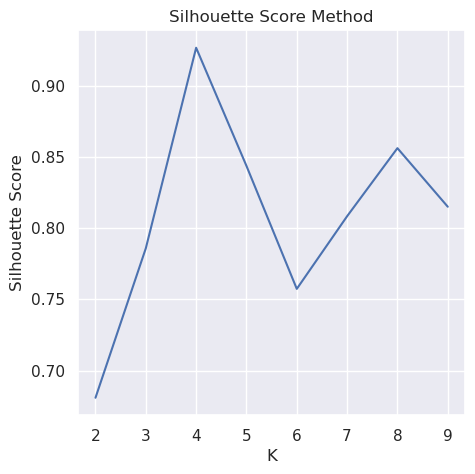

In [31]:
from sklearn.metrics import silhouette_score

sil = []
k_range = range(2,10)
for k in k_range:
    kmeans = KMeans(n_clusters = k).fit(pca_df2)
    labels = kmeans.labels_
    sil.append(silhouette_score(pca_df2, labels, metric = 'euclidean'))
plt.plot(k_range,sil)
plt.title('Silhouette Score Method')
plt.xlabel("K")
plt.ylabel("Silhouette Score")

plt.show()

As we observed, Silhouette Score Method also agrees with the results from elbow method to pick 4 clusters.